## Dynamic Programming Approach to Optimal Control for LTI system
### Carlos Morales

Reference: [CMU Optimal Control Lecture on LQR via Dynamic Programming](https://youtu.be/cgRaP_TYZow?si=kU2eyBlouiIpoAJX&t=1797)

For this example, let's consider discrete-time linear dynamics given by:
$$
x_{k+1} = Ax_k + Bu_k, \quad k = 0,1,\, ... \,,N-1
$$

Say we want to solve the following optimal control problem where we want to regulate the system state, penalize control actuation, and satisfy dynamics constraints.

$$
\begin{aligned}
\min_{u_k} \quad & 
  \sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^TRu_k) + x_N^T Q x_N \\
\text{subject to}\quad & x_{k+1} = Ax_k + Bu_k,\quad k = 0,1, \, ... \, ,N-1
\end{aligned}
$$

Assuming Q and R are PSD, this is a convex equality-constrained Quadratic Program (QP) which (due to the lack of inequality constraints) has an analytic solution and can be solved in several ways. To gain more insight however, we can use the principle of optimality and dynamic programming to obtain a solution.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# dynamics and control matrices
A = np.array([[1.0, 0.2],
              [0.0, 1.0]]) 

B = np.array([[0.05],
              [0.2]])  

# cost matrices
Q = np.array([[1.0, 0.0],
              [0.0, 1.0]]) 

R = np.array([[0.2]]) 

# initial state
x0 = np.array([[2.0], 
               [5.0]])

# time horizon
N = 50


To solve the optimal control problem, we can start at the end and solve a sequence of simpler optimization problems backwards in time, i.e. Dynamic Programming. Referring back to the bellman equation which we derived in lecture we can solve a recursive problem given by:

$$
V_k(x_k) = \min_{u_k}(s(x_k,u_k) + V_{k+1}(f(x_k,u_k))) \quad k = N-1,\, ... \,,0
$$

Where the cost-to-go / value function at $k = N$ is given by:

$$
V_N(x_N) = x_N^TP_Nx_N \\
$$

This terminal state is the key motivation behind Dynamic Programming and the reason why we want to solve backwards; it is because we have a final state with a known boundary condition and associated value function that is independent of the control input. Using this known terminal value function, we can leverage the principle of optimality to solve a sequence of small optimal control problems backwards in time to retrieve the full solution.

Given $V_N(x_N)$ we can solve for the value function of a state at time $k = N-1$ given by:

\begin{align}
V_{N-1}(x_{N-1}) &= \min_{u_{N-1}}((1/2)\, x_{N-1}^TQx_{N-1} + (1/2)\, u_{N-1}^TRu_{N-1} + V_N(x_{N})) \\
= V_{N-1}(x_{N-1}) &= \min_{u_{N-1}}((1/2)\, x_{N-1}^TQx_{N-1} + (1/2)\, u_{N-1}^TRu_{N-1} + V_N(Ax_{N-1} + Bu_{N-1}))\\
= V_{N-1}(x_{N-1}) &= \min_{u_{N-1}}((1/2)\, x_{N-1}^TQx_{N-1} + (1/2)\, u_{N-1}^TRu_{N-1} + (1/2)\,(Ax_{N-1} + Bu_{N-1})^T P_N(Ax_{N-1} + Bu_{N-1})) 
\end{align}

We can solve this unconstrained convex quadratic problem by setting the gradient equal to zero:

\begin{align}
\nabla_u((1/2)\, x_{N-1}^TQx_{N-1} + (1/2)\, u_{N-1}^TRu_{N-1} + (1/2)\,(Ax_{N-1} + Bu_{N-1})^T P_N(Ax_{N-1} + Bu_{N-1}))  &= 0 \\
Ru_{N-1} + B^TP_N(Ax_{N-1} + Bu_{N-1})&= 0 \\
\end{align}

$\rightarrow \boxed{u_{N-1}^* = -(R+B^TP_NB)^{-1}B^TP_NAx_{N-1}} $

define $K_{N-1} = (R+B^TP_NB)^{-1}B^TP_NA$

$\rightarrow \boxed{u_{N-1}^* = K_{N-1}x_{N-1}}$

We now how the optimal control input we'd need to apply from a state at $t=N-1$, we can plug this back in to our definition of the value function $V_{N-1}(x_{N-1})$:

$$
\begin{aligned}
V_{N-1}(x_{N-1}) &= ((1/2)\, x_{N-1}^TQx_{N-1} + (1/2)\, x_{N-1}^TK_{N-1}^TRK_{N-1}x_{N-1} + (1/2)\,(Ax_{N-1} - BK_{N-1}x_{N-1})^T P_N(Ax_{N-1} - BK_{N-1}x_{N-1})) \\
&= (1/2)x_{N-1}^T(Q + K_{N-1}^TRK_{N-1} + (A - BK_{N-1})^T P_N(A - BK_{N-1}))x_{N-1}
\end{aligned}
$$

where now we identify $\boxed{P_{N-1} = (Q + K_{N-1}^TRK_{N-1} + (A - BK_{N-1})^T P_N(A - BK_{N-1}))}$


Notice that the cost-to-go at $k = N-1$ is another quadratic, so from here we see that we can continue this process by now solving for $u_{N-2}^* \, , u_{N-3}^* \,  , \, ... $ until we get to $u_{0}^*$ by which point we would have a full trajectory of optimal control inputs.

Below is the code that implements this recursion where we can solve for each DP iterate by solving for the current optimal gain K and corresponding cost-to-go matrix P:


In [2]:
# list of cost-to-go and control gain matrices
P = np.zeros((N, 2, 2))  
K = np.zeros((N, 1, 2))

# state and control trajectories
x_traj = np.zeros((N, 2, 1))  
u_traj = np.zeros((N-1, 1, 1)) 

# set final cost
P[-1] = Q

# backwards iteration solving for the cost-to-go and optimal control gain matrices
for k in range(N-2, -1, -1):
    K[k] = np.linalg.inv(R + B.T @ P[k+1] @ B) @ B.T @ P[k+1] @ A
    P[k] = Q + K[k].T @ R @ K[k] + (A - B @ K[k]).T @ P[k+1] @ (A - B @ K[k])

Below we simulate and plot the resulting controller

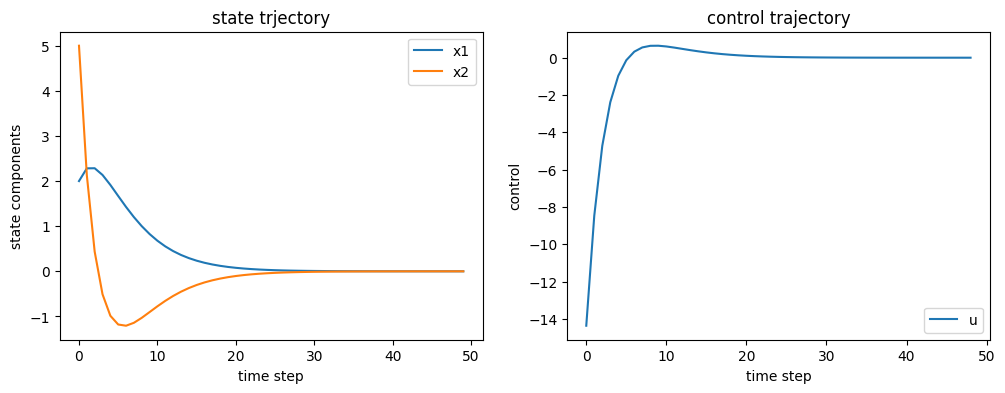

In [3]:
# simulate the system
x_traj[0] = x0
for k in range(N-1):
    u = -K[k] @ x_traj[k] 
    x_traj[k+1] = A @ x_traj[k] + B @ u
    u_traj[k] = u

#plot the simulation results
t = np.arange(N)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(t, x_traj[:, 0], label='x1')
plt.plot(t, x_traj[:, 1], label='x2')
plt.legend()
plt.xlabel('time step')
plt.ylabel('state components')
plt.title('state trjectory')


plt.subplot(1, 2, 2)
plt.plot(t[:-1], u_traj[:, 0], label='u')
plt.legend()
plt.xlabel('time step')
plt.ylabel('control')
plt.title('control trajectory')

plt.show()